# <center> Luminol [github](https://github.com/linkedin/luminol)</center>
Paquete creado por LinkedIn. Hace 2 cosas:
1. Detecta mediante varios (4) algoritmos valores anómalos en una serie temporal.
1. También puede comprobar la correlación entre dos series temporales. <br>Útil para conocer la correlación entre dos ST columnas de un dataset.


In [17]:
import luminol
from luminol import anomaly_detector
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
sns.set()

"""
    # Carga y prepara los datos
"""
# path = '/home/jtauste/PycharmProjects/apuntes/time_series/data/raw/AirPassengers.csv'
path = '/home/jtauste/PycharmProjects/apuntes/time_series/data/raw/daily-total-female-births.csv'
path = '/home/jtauste/PycharmProjects/apuntes/time_series/data/raw/SP5002.csv'
# path = '/home/jtauste/PycharmProjects/apuntes/time_series/data/raw/U.S._Crude_Oil_First_Purchase_Price.csv'

df = pd.read_csv(path, 
                 header=0, 
                 parse_dates=True, # True parse index. [[1,3]] combiana cols 1y3 en datetime. {‘date’:[1,3]} creando col 'date'
                 infer_datetime_format=True, # Infiere el 1º y los hace todos igual (10xfaster)
                 index_col=0, 
                 na_values=['NULL', 'NaN', 'n/a', 'nan', 'null']) # Qué valores consideramos como Nan

name_values = 'Close'
print(df.shape)
df = df.iloc[18000:,3].to_frame()
display(df)
ts = df.reset_index().to_dict('dict')[name_values]

display(df.head())




# def plot_dates_values(data, title):
#     dates = data["timestamp"].to_list()
#     values = data["value"].to_list()
#     dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
#     plt.figure(figsize=(17,3))
#     plt.subplots_adjust(bottom=0.2)
#     plt.xticks(rotation=25)
#     ax = plt.gca() 
#     xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
#     ax.xaxis.set_major_formatter(xfmt)
#     plt.title(title)
#     plt.plot(dates, values)
#     plt.show()
    
# plot_dates_values(df_train, "train")

(23255, 6)


Close
Date                   
1999-10-08  1336.020020
1999-10-11  1335.209961
1999-10-12  1313.040039
1999-10-13  1285.550049
1999-10-14  1283.420044
...                 ...
2020-08-20  3385.510010
2020-08-21  3397.159912
2020-08-24  3431.280029
2020-08-25  3443.620117
2020-08-26  3478.729980

[5255 rows x 1 columns]

Close
Date                   
1999-10-08  1336.020020
1999-10-11  1335.209961
1999-10-12  1313.040039
1999-10-13  1285.550049
1999-10-14  1283.420044

In [18]:
def detect_anomalies(algorithm_name=None, anomaly_params=None, threshold_outlier=0.0):

    """
        # Detección de anomalías
    """
    ts = df.reset_index().to_dict('dict')[name_values]
    detector = anomaly_detector.AnomalyDetector(ts, 
                                                algorithm_name=algorithm_name,
                                                algorithm_params=anomaly_params)
    anomalies = detector.get_all_scores()

    anomalies_values = []
    for timestamp, value in anomalies.iteritems():
        anomalies_values.append(value)
    #     print(timestamp, value)

    df['anomalies_values'] = anomalies_values
    df['outlier'] = np.where( df['anomalies_values']>threshold_outlier, 'yes', 'no' )
    # display(df)
    print("Máximo valor:", df['anomalies_values'].max())

    """ 
        # Start print 
    """
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15, 7))

    ax1 = fig.add_subplot(111)
    legend=[]

    sns.lineplot(x=list( df.index ), 
                 y=df[name_values],
    #              marker='o',
                 ax=ax1)

    # sns.set_palette(sns.color_palette("Paired"))
    colors = ["#bbd4fc", "#eb26da"]
    sns.set_palette(sns.color_palette(colors))

    sns.scatterplot(x=df.index, 
    #              y=anomalies_values,
                 y=df[name_values],
                 marker='o',
                 s=42,
                 hue=df['outlier'],
                 ax=ax1)

    ax1.legend(legend, bbox_to_anchor=(1.1, 1.0))
    ax1.title.set_text(algorithm_name) 
    plt.show()

Máximo valor: 5.956027107150394


Máximo valor: 5.956027107150394


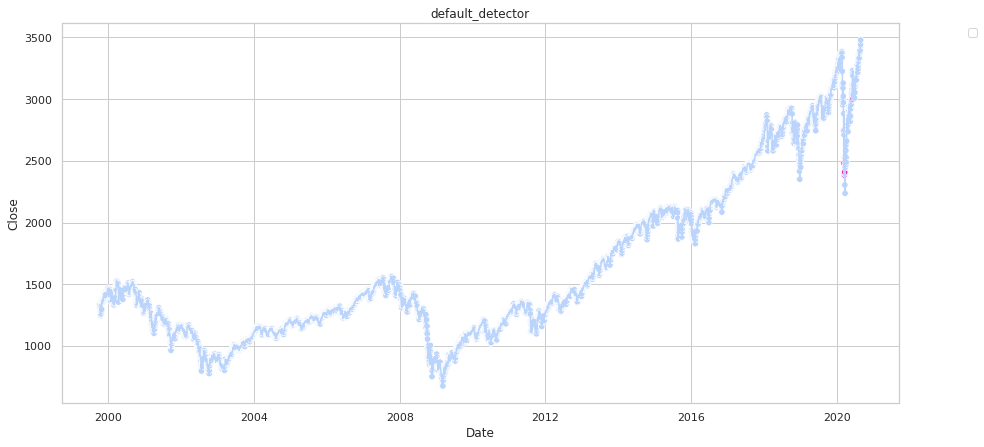

Máximo valor: 16.375018723295145


Máximo valor: 0.5741195702827417


In [20]:
    
"""
    # Configuración del algoritmo detector de anomalías
"""

dict_configuration = {
    'bitmap_detector': # behaves well for huge data sets, and it is the default detector.
    # Assumption-Free Anomaly Detection in Time Series. Figure 1
    # This method breaks time series into chunks and uses the frequency of similar chunks
    # to determine anomaly scores.
    {
        'precision': 4, # Niveles de cuantización
        'lag_window_size': 4, # lagging window size, cuan lejos mirar para comparar con valores anteriores
        'future_window_size': 4, # future window size, ha de ser igual que lagging window
        'chunk_size': 5 # chunk size. feature window
    },
    'default_detector':{}, # used when other algorithms fails, not meant to be explicitly used. Es bitmap_detector
    'derivative_detector': # meant to be used when abrupt changes of value are of main interest.
    # Instead of data point value, it uses the derivative of the data point.
    {
        'smoothing_factor': 0.2 # smoothing factor used to compute exponential moving averages
                                # of derivatives.
    },
    'exp_avg_detector': # meant to be used when values are in a roughly stationary range.
                        # and it is the default refine algorithm.
    # This method uses a data point's deviation from the exponential moving average of a lagging window
    # to determine its anomaly score.
    {
        'smoothing_factor': 0.2, # smoothing factor used to compute exponential moving averages.
        'lag_window_size': 20, # lagging window size.
        'use_lag_window': False # if asserted, a lagging window of size lag_window_size will be used.
    }
}

thresholds = {'bitmap_detector':3.5,
              'default_detector':3.5,
              'derivative_detector':3.5,
              'exp_avg_detector':0.35,}

for key, value in dict_configuration.items():
    detect_anomalies(key, value, thresholds[key])

In [297]:
"""
    # AÑADIDO: Correlación entre varias ST
"""

from luminol.anomaly_detector import AnomalyDetector
from luminol.correlator import Correlator

ts1 = {0: 0, 1: 0.5, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0}
ts2 = {0: 0, 1: 0.5, 2: 1, 3: 0.5, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1}

my_detector = AnomalyDetector(ts1, score_threshold=1.5)
score = my_detector.get_all_scores()
anomalies = my_detector.get_anomalies()
for a in anomalies:
    time_period = a.get_time_window()
    my_correlator = Correlator(ts1, ts2, time_period)
    if my_correlator.is_correlated(threshold=0.8):
        print("ts2 correlaciona con ts1 entre los periodos (%d, %d)" % time_period)

ts2 correlaciona con ts1 entre los periodos (2, 5)


# IsolationForest (Sklearn) [manual1](https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html) [manual2](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

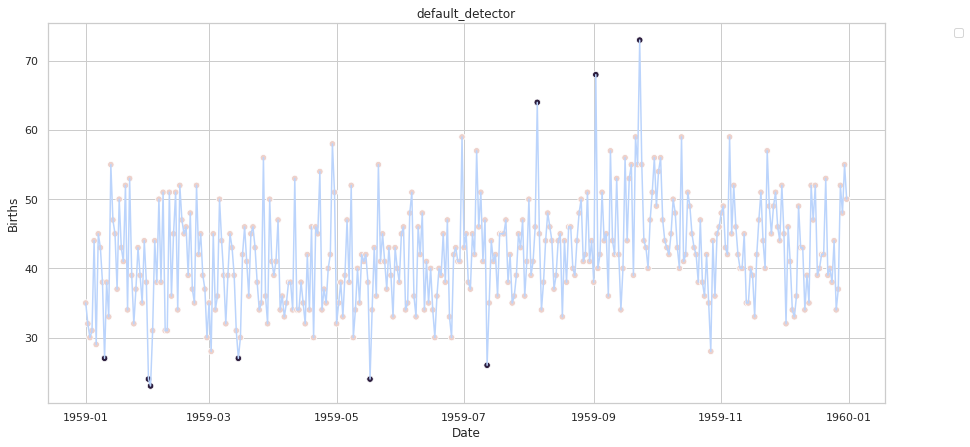

In [346]:
from sklearn.ensemble import IsolationForest

X = [[i] for i in df[name_values].tolist()]
clf = IsolationForest(max_samples=50, contamination=0.025, random_state=42).fit(X)
X_pred = clf.predict(X)

df_isolation = pd.DataFrame()
df_isolation['Births'] = df[name_values]
df_isolation['is_outlier'] = X_pred * -1
# display( df_isolation )


sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(111)
legend=[]

sns.lineplot(x=list( df.index ), 
             y=df[name_values],
#              marker='o',
             ax=ax1)

# sns.set_palette(sns.color_palette("Paired"))
colors = ["#bbd4fc", "#eb26da"]
sns.set_palette(sns.color_palette(colors))

sns.scatterplot(x=df_isolation.index, 
             y=df_isolation['Births'],
             marker='o',
             s=42,
             hue=df_isolation['is_outlier'],
             ax=ax1)

ax1.legend(legend, bbox_to_anchor=(1.1, 1.0))
ax1.title.set_text(algorithm_name) 
plt.show()

In [354]:
luminol

<module 'luminol' from '/home/jtauste/.local/lib/python3.7/site-packages/luminol/__init__.py'>